# Exploração BRICS World Bank Indicators

**Importação de bibliotecas**

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from IPython.display import HTML, Markdown, display
import numpy as np
from sklearn import model_selection as ms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

**Carregamento dos datasets originais**

In [2]:
eco = pd.read_csv("data/Economy_Data.csv", sep=";")
private = pd.read_csv("data/PrivateSector_Data.csv", sep=";")
public = pd.read_csv("data/PublicSector_Indicators.csv", sep=";")
health = pd.read_csv("data/HealthAndPoverty_Data.csv", sep=";")
edu = pd.read_csv("data/EducationAndEnviron_Data.csv", sep=";")

## Estruturação do dataframe
___

- Concatenação dos datasets em uma dataframe único

In [3]:
df = pd.concat([eco, private, public, health, edu]).dropna()
df

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
5,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,Brazil,BRA,1970.0,3.918974e+11
7,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,India,IND,1970.0,1.915335e+11
10,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,Brazil,BRA,1970.0,3.786021e+10
11,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,China,CHN,1970.0,8.525561e+10
12,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,India,IND,1970.0,5.776720e+10
...,...,...,...,...,...,...
71480,Urban population growth (annual %),SP.URB.GROW,Brazil,BRA,2019.0,1.045678e+00
71481,Urban population growth (annual %),SP.URB.GROW,China,CHN,2019.0,2.292727e+00
71482,Urban population growth (annual %),SP.URB.GROW,India,IND,2019.0,2.305597e+00
71483,Urban population growth (annual %),SP.URB.GROW,Russian Federation,RUS,2019.0,1.344493e-01


- Seleção dos dados da `China`

In [4]:
df = df[:][df["CountryCode"] == "CHN"]

- Contagem das instâncias de informações (nº de registros)

In [5]:
counts = df["SeriesName"].value_counts()
counts

Urban population                                                      50
Population ages 45-49, female (% of female population)                50
Population ages 30-34, female (% of female population)                50
Population ages 30-34, male (% of male population)                    50
Population ages 35-39, female (% of female population)                50
                                                                      ..
Firms with female participation in ownership (% of firms)              1
Firms visited or required meetings with tax officials (% of firms)     1
Firms using banks to finance working capital (% of firms)              1
Firms using banks to finance investment (% of firms)                   1
Plant species (higher), threatened                                     1
Name: SeriesName, Length: 1111, dtype: int64

- Identificação das informações mais completas (com dados referentes aos 50 anos de registro)

In [6]:
filtered_info = counts[:][counts >= 50]
filtered_info.shape

(126,)

- Seleção das informações e Remoção de informações duplicadas

In [7]:
df = df[:][df["SeriesName"].isin(list(filtered_info.keys()))].drop_duplicates()
df

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
141,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,China,CHN,1970.0,3.479844e+01
146,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KD.ZG,China,CHN,1970.0,7.700000e+00
151,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KD,China,CHN,1970.0,1.248314e+11
156,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KN,China,CHN,1970.0,1.040250e+12
161,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.CN,China,CHN,1970.0,7.933000e+10
...,...,...,...,...,...,...
71156,Rural population growth (annual %),SP.RUR.TOTL.ZG,China,CHN,2019.0,-2.513529e+00
71286,"Secondary education, duration (years)",SE.SEC.DURS,China,CHN,2019.0,6.000000e+00
71471,Urban population,SP.URB.TOTL,China,CHN,2019.0,8.429340e+08
71476,Urban population (% of total population),SP.URB.TOTL.IN.ZS,China,CHN,2019.0,6.030800e+01


- *Reshape* da dataframe baseado em `Year`, `SeriesName` e `Value`

In [8]:
df_meas = df.pivot(index="Year", columns="SeriesName", values="Value")
df_meas

SeriesName,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added (annual % growth)","Agriculture, forestry, and fishing, value added (constant 2010 US$)","Agriculture, forestry, and fishing, value added (constant LCU)","Agriculture, forestry, and fishing, value added (current LCU)","Agriculture, forestry, and fishing, value added (current US$)",Arms exports (SIPRI trend indicator values),...,Rural population,Rural population (% of total population),Rural population growth (annual %),"Secondary education, duration (years)","Services, value added (% of GDP)","Services, value added (current LCU)",Trade (% of GDP),Urban population,Urban population (% of total population),Urban population growth (annual %)
Year,,,,,,,,,,,,,,,,,,,,,
1970.0,79.067857,6.711511,72.356346,34.798438,7.700000,1.248314e+11,1.040250e+12,7.933000e+10,3.222439e+10,8.930000e+08,...,675928190.0,82.600,2.916759,4.0,24.928719,5.683000e+10,4.952406,142386810.0,17.400,2.028736
1971.0,79.343397,6.844092,72.499305,33.631812,1.900000,1.272031e+11,1.060015e+12,8.263000e+10,3.356487e+10,1.292000e+09,...,695661123.0,82.708,2.877581,4.0,24.445439,6.006000e+10,4.920835,145443877.0,17.292,2.124292
1972.0,79.485458,6.965496,72.519962,32.416549,-0.900000,1.260583e+11,1.050475e+12,8.274000e+10,3.685359e+10,1.238000e+09,...,713898765.0,82.816,2.587852,4.0,24.811942,6.333000e+10,5.755367,148131235.0,17.184,1.830832
1973.0,79.486645,7.078791,72.407855,32.925767,9.000000,1.374036e+11,1.145017e+12,9.075000e+10,4.561677e+10,6.740000e+08,...,730387430.0,82.816,2.283395,4.0,24.250780,6.684000e+10,8.000145,151552570.0,17.184,2.283396
1974.0,79.153557,7.184947,71.968610,33.426460,4.100000,1.430371e+11,1.191963e+12,9.452000e+10,4.819498e+10,5.110000e+08,...,744661478.0,82.708,1.935460,4.0,24.143297,6.827000e+10,10.333487,155688522.0,17.292,2.692480
1975.0,78.335005,7.284008,71.050997,31.952624,2.000000,1.458979e+11,1.215802e+12,9.712000e+10,5.222067e+10,6.680000e+08,...,756942270.0,82.600,1.635727,4.0,22.687942,6.896000e+10,9.554203,159452730.0,17.400,2.389016
1976.0,76.933619,7.425673,69.507946,32.359633,-1.800000,1.432717e+11,1.193918e+12,9.671000e+10,4.981457e+10,5.860000e+08,...,768187399.0,82.540,1.474672,4.0,22.605902,6.756000e+10,8.836914,162497601.0,17.460,1.891572
1977.0,75.208477,7.554590,67.653887,28.990769,-2.200000,1.401197e+11,1.167652e+12,9.422000e+10,5.071590e+10,2.240000e+08,...,778161684.0,82.480,1.290061,5.0,24.310769,7.901000e+10,8.384615,165293316.0,17.520,1.705833
1978.0,73.157321,7.671250,65.486071,27.685418,-1.120491,1.385497e+11,1.154568e+12,1.018464e+11,4.140098e+10,6.170000e+08,...,785011465.0,82.100,0.876400,6.0,24.603171,9.050775e+10,9.650142,171153535.0,17.900,3.483945


## Seleção de *features*
___

### Verificação da Correlação

- Seleção de algumas colunas (removendo colunas de nomes similares)

In [9]:
nomes = list(df_meas.keys())
escolhidos = []
escolhidos_tmp = []

for nome in nomes:
    subnomes = "_".join(nome.split(" ")[0:2])
    if subnomes not in escolhidos_tmp:
        escolhidos_tmp.append(subnomes)
        escolhidos.append(nome)
print(escolhidos)

['Age dependency ratio (% of working-age population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Arms exports (SIPRI trend indicator values)', 'Arms imports (SIPRI trend indicator values)', 'Exports of goods and services (% of GDP)', 'External balance on goods and services (% of GDP)', 'GDP (constant 2010 US$)', 'GDP (current LCU)', 'GDP growth (annual %)', 'GDP per capita (constant 2010 US$)', 'GNI (current LCU)', 'GNI per capita (current LCU)', 'GNI, Atlas method (current US$)', 'Imports of goods and services (% of GDP)', 'Industry (including construction), value added (% of GDP)', 'Lower secondary school starting age (years)', 'Merchandise exports (current US$)', 'Merchandise imports (current US$)', 'Merchandise trade (% of GDP)', 'Mortality rate, infant (per 1,000 live births)', 'Number of infant deaths', 'Population ages 0-14 (% of total population)', 'Population growth (annual %)', 'Population in largest city', 'Population, female', 'Population, male', 'Popul

- Visualização da correlação de algumas colunas

In [10]:
df_meas2 = df_meas[escolhidos]

cm = sns.color_palette("coolwarm", as_cmap=True)
corr = df_meas2.corr()
corr.style.background_gradient(cmap=cm)

SeriesName,Age dependency ratio (% of working-age population),"Agriculture, forestry, and fishing, value added (% of GDP)",Arms exports (SIPRI trend indicator values),Arms imports (SIPRI trend indicator values),Exports of goods and services (% of GDP),External balance on goods and services (% of GDP),GDP (constant 2010 US$),GDP (current LCU),GDP growth (annual %),GDP per capita (constant 2010 US$),GNI (current LCU),GNI per capita (current LCU),"GNI, Atlas method (current US$)",Imports of goods and services (% of GDP),"Industry (including construction), value added (% of GDP)",Lower secondary school starting age (years),Merchandise exports (current US$),Merchandise imports (current US$),Merchandise trade (% of GDP),"Mortality rate, infant (per 1,000 live births)",Number of infant deaths,Population ages 0-14 (% of total population),Population growth (annual %),Population in largest city,"Population, female","Population, male","Population, total","Primary education, duration (years)",Primary school starting age (years),Rural population,"Secondary education, duration (years)","Services, value added (% of GDP)",Trade (% of GDP),Urban population
SeriesName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Age dependency ratio (% of working-age population),1.000000,0.928025,-0.174035,-0.707931,-0.910642,-0.575499,-0.716252,-0.635679,-0.180956,-0.727618,-0.635367,-0.646795,-0.604581,-0.931431,-0.049150,nan,-0.683628,-0.688297,-0.901108,0.949090,0.926785,0.986744,0.895253,-0.851058,-0.974857,-0.975151,-0.975014,-0.698895,0.698895,0.303732,-0.758960,-0.891398,-0.925002,-0.882589
"Agriculture, forestry, and fishing, value added (% of GDP)",0.928025,1.000000,-0.055530,-0.749164,-0.881128,-0.591940,-0.847402,-0.779900,-0.060200,-0.856029,-0.779547,-0.789547,-0.747410,-0.889803,-0.020803,nan,-0.811274,-0.813284,-0.818843,0.940919,0.908040,0.964457,0.900867,-0.953488,-0.973942,-0.974718,-0.974347,-0.794569,0.794569,0.523736,-0.570813,-0.968533,-0.889862,-0.962799
Arms exports (SIPRI trend indicator values),-0.174035,-0.055530,1.000000,-0.309000,-0.069287,-0.248635,0.307325,0.340330,0.094586,0.304373,0.340078,0.336351,0.376564,-0.004085,-0.471628,nan,0.335456,0.329163,-0.052564,-0.202319,-0.094897,-0.187443,-0.008635,0.187374,0.115462,0.115800,0.115637,0.206918,-0.206918,-0.303036,0.186304,0.171469,-0.040253,0.202663
Arms imports (SIPRI trend indicator values),-0.707931,-0.749164,-0.309000,1.000000,0.828469,0.592704,0.435505,0.344386,0.159301,0.446072,0.343898,0.355199,0.297655,0.824843,0.226863,nan,0.382921,0.390992,0.795198,-0.645215,-0.663513,-0.703547,-0.688923,0.630721,0.719459,0.719935,0.719708,0.510886,-0.510886,-0.173093,0.403933,0.672989,0.831366,0.632729
Exports of goods and services (% of GDP),-0.910642,-0.881128,-0.069287,0.828469,1.000000,0.769274,0.595694,0.496457,0.229666,0.609175,0.496361,0.510568,0.450771,0.978065,0.263952,nan,0.586415,0.593386,0.966686,-0.841109,-0.832873,-0.898511,-0.829947,0.776790,0.882566,0.884244,0.883434,0.723478,-0.723478,-0.264482,0.579761,0.792254,0.995575,0.795756
External balance on goods and services (% of GDP),-0.575499,-0.591940,-0.248635,0.592704,0.769274,1.000000,0.384216,0.302164,0.088251,0.394772,0.302489,0.314790,0.258870,0.619314,0.276818,nan,0.395214,0.382364,0.655928,-0.525567,-0.529060,-0.579749,-0.531874,0.538017,0.572209,0.574598,0.573441,0.560813,-0.560813,-0.228431,0.252715,0.507461,0.705833,0.537357
GDP (constant 2010 US$),-0.716252,-0.847402,0.307325,0.435505,0.595694,0.384216,1.000000,0.992071,-0.121855,0.999817,0.992028,0.994076,0.983742,0.606765,-0.338959,nan,0.983067,0.976936,0.481552,-0.848227,-0.758352,-0.816871,-0.731938,0.960764,0.807508,0.808641,0.808096,0.872662,-0.872662,-0.853001,0.351367,0.909511,0.603947,0.952145
GDP (current LCU),-0.635679,-0.779900,0.340330,0.344386,0.496457,0.302164,0.992071,1.000000,-0.162284,0.989628,0.999993,0.999816,0.997257,0.511567,-0.406172,nan,0.975756,0.968909,0.379445,-0.789838,-0.694003,-0.746761,-0.665275,0.920015,0.738674,0.739590,0.739150,0.837437,

- **Ordenação das colunas com maior correlação**

In [11]:
# dados_importacao = df_meas.corr()[
#     "Arms imports (SIPRI trend indicator values)"
# ].sort_values(key=lambda x: abs(x), ascending=False)

# a = dados_importacao > 0.5
# b = dados_importacao < -0.5
# dados_importacao[:][a | b].head(50)

In [12]:
# import seaborn as sns; sns.set_theme()
# sns.heatmap(df_meas2.corr())

### Métodos de Seleção de *Features*

- **LogisticRegression**

In [13]:
coluna_Y = ["Arms imports (SIPRI trend indicator values)"]

X = df_meas.drop("Arms imports (SIPRI trend indicator values)", axis=1)
y = df_meas[coluna_Y]

In [14]:
splits = ms.train_test_split(X, y, test_size=0.3, random_state=30)
X_train, X_test, y_train, y_test = splits

scaler = StandardScaler()

scaler_previsores = scaler.fit(X_train)
X_train = scaler_previsores.transform(X_train)
X_test = scaler_previsores.transform(X_test)

In [15]:
# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Variáveis
rfe = RFE(modelo, 20)
fit = rfe.fit(X_train, y_train)

# Print dos resultados
print("Atributos preditores:", df_meas.columns)

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados" 
# e com valor 1 em "Ranking dos Atributos"): preg, plas, mass e pedi.
# (Basta mapear manualmente o índice dos nomes dos respectivos atributos)
print("\nAtributos selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)

Atributos preditores: Index(['Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio, young (% of working-age population)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'Agriculture, forestry, and fishing, value added (constant 2010 US$)',
       'Agriculture, forestry, and fishing, value added (constant LCU)',
       'Agriculture, forestry, and fishing, value added (current LCU)',
       'Agriculture, forestry, and fishing, value added (current US$)',
       'Arms exports (SIPRI trend indicator values)',
       ...
       'Rural population', 'Rural population (% of total population)',
       'Rural population growth (annual %)',
       'Secondary education, duration (years)',
       'Services, value added (% of GDP)',
       'Services, value added (current LCU)', 'Trade (% of GDP)',
     

In [16]:
print("> 20 Melhores features:")
X.T[:][fit.support_].index.tolist()

> 20 Melhores features:


['Agriculture, forestry, and fishing, value added (annual % growth)',
 'Arms exports (SIPRI trend indicator values)',
 'External balance on goods and services (% of GDP)',
 'External balance on goods and services (current LCU)',
 'External balance on goods and services (current US$)',
 'GDP growth (annual %)',
 'GDP per capita growth (annual %)',
 'Imports of goods and services (% of GDP)',
 'Industry (including construction), value added (% of GDP)',
 'Population ages 15-19, female (% of female population)',
 'Population ages 15-19, male (% of male population)',
 'Population ages 20-24, female (% of female population)',
 'Population ages 20-24, male (% of male population)',
 'Population ages 25-29, female (% of female population)',
 'Population ages 25-29, male (% of male population)',
 'Population ages 30-34, female (% of female population)',
 'Population ages 30-34, male (% of male population)',
 'Population ages 35-39, male (% of male population)',
 'Population, male (% of total po

- **SelectKBest**

In [17]:
splits = ms.train_test_split(X, y, test_size=0.3, random_state=30)
X_train, X_test, y_train, y_test = splits

scaler = MinMaxScaler()
scaler_previsores = scaler.fit(X_train)
X_train = scaler_previsores.transform(X_train)
X_test = scaler_previsores.transform(X_test)

In [18]:
# Função para seleção de atributos
best_var = SelectKBest(score_func=chi2, k=20)

# Executa a função de pontuação em (X_train, Y_train) e obtém os atributos selecionados
fit = best_var.fit(X_train, y_train)

# Reduz X para os atributos selecionados
features = fit.transform(X_train)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])


# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas): plas, test, mass e age.
# # (Basta mapear manualmente o índice dos nomes dos respectivos atributos)
# set_printoptions(precision=3) # 3 casas decimais
# print(fit.score)


Número original de atributos: 125

Número reduzido de atributos: 20


In [19]:
print("> 20 Melhores features:")
X.T[:][fit.get_support()].index.tolist()

> 20 Melhores features:


['Exports of goods and services (current LCU)',
 'Exports of goods and services (current US$)',
 'GDP (current LCU)',
 'GDP (current US$)',
 'GDP per capita (current LCU)',
 'GDP per capita (current US$)',
 'GNI (current LCU)',
 'GNI (current US$)',
 'GNI per capita (current LCU)',
 'GNI per capita, Atlas method (current US$)',
 'GNI, Atlas method (current US$)',
 'Imports of goods and services (current LCU)',
 'Imports of goods and services (current US$)',
 'Industry (including construction), value added (current LCU)',
 'Industry (including construction), value added (current US$)',
 'Merchandise exports (current US$)',
 'Merchandise imports (current US$)',
 'Population ages 60-64, female (% of female population)',
 'Primary education, duration (years)',
 'Services, value added (current LCU)']

- Selecionamos colunas indicadas pelos algoritmos de `LogisticRegression` e `SelectKBest`:

In [20]:
# colunas_X = [
#     "Trade (% of GDP)",
#     "Population ages 15-64, female (% of female population)",
#     "Agriculture, forestry, and fishing, value added (% of GDP)",
#     "Rural population growth (annual %)",
#     "Age dependency ratio (% of working-age population)",
#     "Population in urban agglomerations of more than 1 million (% of total population)",
# ]
coluna_Y = ["Arms imports (SIPRI trend indicator values)"]

# colunas_X = ['Agriculture, forestry, and fishing, value added (annual % growth)',
#        'Arms exports (SIPRI trend indicator values)',
#        'External balance on goods and services (% of GDP)',
#        'External balance on goods and services (current LCU)',
#        'External balance on goods and services (current US$)',
#        'GDP growth (annual %)', 'GDP per capita growth (annual %)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Population ages 15-19, female (% of female population)',
#        'Population ages 15-19, male (% of male population)',
#        'Population ages 20-24, female (% of female population)',
#        'Population ages 20-24, male (% of male population)',
#        'Population ages 25-29, female (% of female population)',
#        'Population ages 25-29, male (% of male population)',
#        'Population ages 30-34, female (% of female population)',
#        'Population ages 30-34, male (% of male population)',
#        'Population ages 35-39, male (% of male population)',
#        'Population, male (% of total population)',
#        'Urban population growth (annual %)']     #best

colunas_X =[
       'Exports of goods and services (current US$)',
       'GDP (current US$)',
       'GDP per capita (current US$)', 
       'GNI (current US$)', 
       'GNI per capita, Atlas method (current US$)',
       'GNI, Atlas method (current US$)',
       'Imports of goods and services (current US$)',
       'Industry (including construction), value added (current US$)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)',
       'Population ages 60-64, female (% of female population)',
       'Primary education, duration (years)',
       'Services, value added (current LCU)',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'External balance on goods and services (% of GDP)',
       'GDP growth (annual %)', 'GDP per capita growth (annual %)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Population ages 15-19, male (% of male population)',
       'Population ages 20-24, male (% of male population)',
       'Population ages 25-29, male (% of male population)',
       'Population ages 30-34, male (% of male population)',
       'Population ages 35-39, male (% of male population)',
       'Population, male (% of total population)',
       'Urban population growth (annual %)']

# X = df_meas.drop("Arms imports (SIPRI trend indicator values)", axis=1)

X = df_meas[colunas_X]
y = df_meas[coluna_Y]

## Avaliação de vários modelos
___

In [21]:
from lazypredict.Supervised import LazyRegressor

splits = ms.train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = splits

scaler = StandardScaler()
scaler_previsores = scaler.fit(X_train)
X_train = scaler_previsores.transform(X_train)
X_test = scaler_previsores.transform(X_test)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 42/42 [00:01<00:00, 25.57it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,9351510118.89,-8015580100.05,84801175219211.75,0.02
LinearSVR,3.30,-0.97,1329762661.03,0.03
MLPRegressor,3.30,-0.97,1329762646.45,0.14
PassiveAggressiveRegressor,3.30,-0.97,1329738120.04,0.02
TransformedTargetRegressor,2.84,-0.58,1190534766.45,0.01
LinearRegression,2.84,-0.58,1190534766.45,0.01
LassoLars,2.84,-0.58,1190176463.70,0.02
KernelRidge,2.64,-0.41,1123295586.23,0.02
NuSVR,2.24,-0.06,976953493.89,0.01


## Modelos de Regressão
___

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline

pipe = Pipeline([("Scaler", MinMaxScaler()), ("Linear", ExtraTreesRegressor(random_state=0))])
params = {"Linear__min_samples_leaf": np.arange(1, 6), 
          "Linear__n_estimators": np.arange(100, 102), 
          "Linear__criterion": ["mse", "mae"]}

extra_grid = GridSearchCV(pipe, params, scoring='r2')
extra_grid.fit(X_train, y_train)

print("Melhor valor de K para 'min_samples_leaf': {0}".format(extra_grid.best_params_['Linear__min_samples_leaf']))
print("Melhor valor para n_estimators: {0}".format( extra_grid.best_params_['Linear__n_estimators']))
print("Melhor valor para peso: {0}".format( extra_grid.best_params_['Linear__criterion']))
print('Melhor r2: {0}'.format(extra_grid.best_score_))

Melhor valor de K para 'min_samples_leaf': 1
Melhor valor para n_estimators: 100
Melhor valor para peso: mse
Melhor r2: 0.7992823598629466


In [24]:
pipe = Pipeline([("Scaler", StandardScaler()), ("Linear", ExtraTreesRegressor(random_state=0))])
params = {"Linear__min_samples_leaf": np.arange(1, 6), 
          "Linear__n_estimators": np.arange(100, 102), 
          "Linear__criterion": ["mse", "mae"]}

extra_grid = GridSearchCV(pipe, params, scoring='r2')
extra_grid.fit(X_train, y_train)

print("Melhor valor de K para 'min_samples_leaf': {0}".format(extra_grid.best_params_['Linear__min_samples_leaf']))
print("Melhor valor para n_estimators: {0}".format( extra_grid.best_params_['Linear__n_estimators']))
print("Melhor valor para peso: {0}".format( extra_grid.best_params_['Linear__criterion']))
print('Melhor r2: {0}'.format(extra_grid.best_score_))

Melhor valor de K para 'min_samples_leaf': 1
Melhor valor para n_estimators: 100
Melhor valor para peso: mse
Melhor r2: 0.7992823598629466


In [25]:
# %%time
# pipe = Pipeline([("Linear", ExtraTreesRegressor(random_state=0))])
# params = {"Linear__min_samples_leaf": np.arange(1, 6), 
#           "Linear__n_estimators": np.arange(140, 200), 
#           "Linear__criterion": ["mse", "mae"]}

# extra_grid = GridSearchCV(pipe, params, scoring='r2')
# extra_grid.fit(X_train, y_train)

# print("Melhor valor de K para 'min_samples_leaf': {0}".format(extra_grid.best_params_['Linear__min_samples_leaf']))
# print("Melhor valor para n_estimators: {0}".format( extra_grid.best_params_['Linear__n_estimators']))
# print("Melhor valor para peso: {0}".format( extra_grid.best_params_['Linear__criterion']))
# print('Melhor r2: {0}'.format(extra_grid.best_score_))

Melhor valor de K para 'min_samples_leaf': 1

Melhor valor para n_estimators: 142

Melhor valor para peso: mae

Melhor r2: 0.7324303725041956

CPU times: user 12min 58s, sys: 7.42 s, total: 13min 5s

Wall time: 13min 6s

In [26]:
# poly = PolynomialFeatures(degree = 2)
# X_poly = poly.fit_transform(X)

l_r2 = []

min_samples_leaf = 4

for random_state in range(50):

    splits = ms.train_test_split(X, y, test_size=0.3, random_state=random_state)
    X_train, X_test, y_train, y_test = splits

    scaler = StandardScaler()

    scaler_previsores = scaler.fit(X_train)
    X_train = scaler_previsores.transform(X_train)
    X_test = scaler_previsores.transform(X_test)
    
#     reg = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train.values.ravel())
#     reg = SVR().fit(X_train, y_train)
#    reg = LinearRegression().fit(X_train, y_train)
#     reg = KNeighborsRegressor(n_neighbors=2, weights="uniform").fit(X_train, y_train)    
#    reg = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf).fit(X_train, y_train)

    reg = ExtraTreesRegressor(n_estimators=142, criterion='mae', random_state=0).fit(X_train, y_train)
#    reg = KNeighborsRegressor(n_neighbors=2, weights='distance').fit(X_train, y_train)

    expected = np.array(y_test)
    predicted = reg.predict(X_test)

    r2 = r2_score(predicted, expected)

    l_r2.append(r2)

arr_r2 = np.array(l_r2)
arr_r2

array([ 0.79237454,  0.6963489 ,  0.59608823,  0.84656674,  0.84984119,
        0.80296642,  0.8990837 ,  0.95429844,  0.78198702,  0.92740221,
        0.8869864 ,  0.82224698,  0.86902261,  0.69414038,  0.93864596,
        0.84973741, -0.24295003,  0.62701582,  0.57924076,  0.76708805,
        0.60534814,  0.80027728,  0.89478677,  0.90698067,  0.85525808,
        0.90125094,  0.88893122,  0.60333696,  0.91534596,  0.59007923,
        0.87844597,  0.76932129,  0.73281904,  0.78757905,  0.78085751,
        0.73995216,  0.92769065,  0.87854461,  0.77747896,  0.80644711,
        0.85985724,  0.84101782,  0.90427277,  0.87027634,  0.89147407,
        0.8225789 ,  0.83943981,  0.42655429,  0.75670012,  0.77116483])

In [27]:
pd.DataFrame(arr_r2).sort_values(by=0, ascending=False).head()

,0
7,0.95
14,0.94
36,0.93
9,0.93
28,0.92


In [28]:
print(f"> Média do R2 Score: {arr_r2.mean()}")

> Média do R2 Score: 0.7792439907671315


In [29]:
print(f"> Variância do R2 Score: {arr_r2.std()}")

> Variância do R2 Score: 0.1836798542937023


**Modelo Final**

In [67]:
splits = ms.train_test_split(X, y, test_size=0.3, random_state=7)
X_train, X_test, y_train, y_test = splits

scaler = StandardScaler()

scaler_previsores = scaler.fit(X_train)
X_train = scaler_previsores.transform(X_train)
X_test = scaler_previsores.transform(X_test)

reg = ExtraTreesRegressor(n_estimators=142, criterion='mae', random_state=0).fit(X_train, y_train)

expected = np.array(y_test)
predicted = reg.predict(X_test)

r2 = r2_score(predicted, expected)
r2

0.9542984423531224

In [62]:
from sklearn.model_selection import cross_validate

X2 = StandardScaler().fit_transform(X)
reg = ExtraTreesRegressor(n_estimators=142, criterion='mae', random_state=7)

scoring = ["r2", "neg_mean_squared_error"]
scores = cross_validate(reg, np.array(X2), np.array(y).ravel(), cv=5, scoring=scoring)
scores

{'fit_time': array([0.19706416, 0.18329287, 0.17398119, 0.17844796, 0.21287465]),
 'score_time': array([0.00986648, 0.00787902, 0.00720835, 0.00711107, 0.01118851]),
 'test_r2': array([-30.48488265, -32.40883052,  -1.15347554,  -4.0180743 ,
         -3.75681291]),
 'test_neg_mean_squared_error': array([-3.01149754e+16, -1.21442435e+17, -5.37693748e+17, -2.28328583e+18,
        -2.61039432e+17])}

In [65]:
from sklearn.model_selection import cross_val_score

X2 = StandardScaler().fit_transform(X)
reg = ExtraTreesRegressor(n_estimators=142, criterion='mae', random_state=0)

scores = cross_val_score(reg, X2, y, cv=5, scoring='r2')
scores

array([-149.71296683,  -29.22511985,   -0.76190525,   -3.63820082,
         -4.78540317])

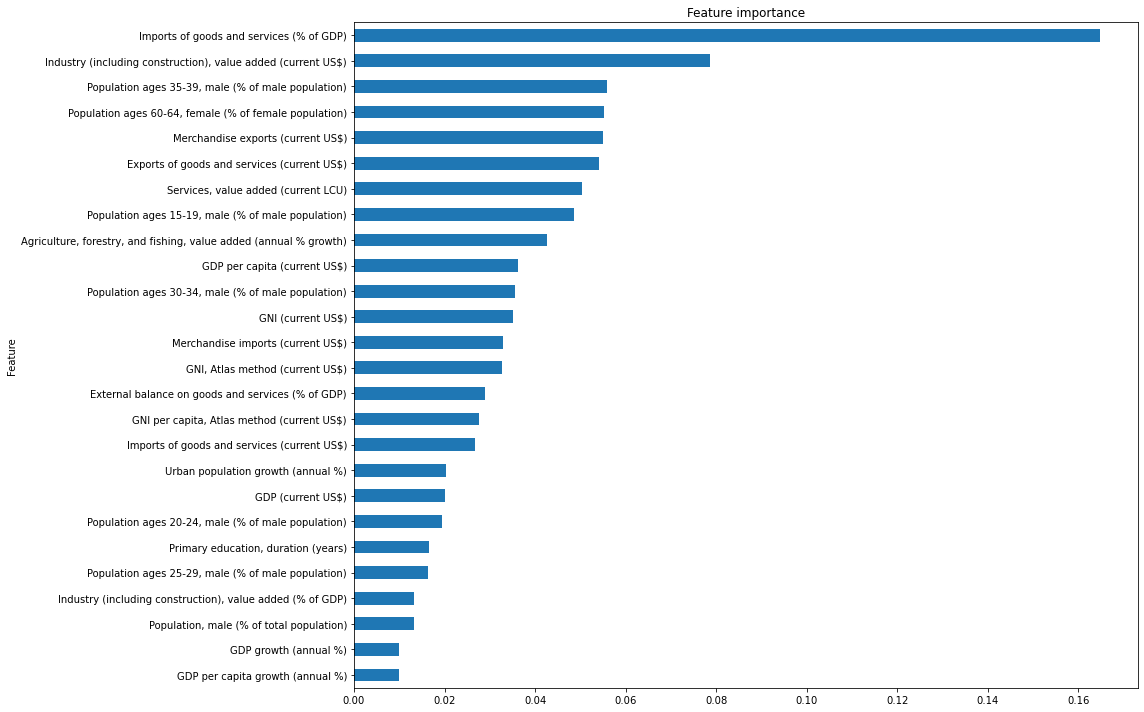

In [32]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(reg.feature_importances_, index=X.columns)

fig, ax = plt.subplots(figsize=(16, 10))
feature_importances.sort_values(ascending=True).plot.barh(ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
fig.tight_layout()

### GridSearch para KNeighborsRegressor

In [33]:
pipe = Pipeline([("scaler", StandardScaler()), ("knnr", KNeighborsRegressor())]) 
parameters1 = {'knnr__n_neighbors': np.arange(2,20),
               'knnr__weights': ['uniform', 'distance']}

knnr_grid2 = GridSearchCV(pipe, parameters1,  scoring='r2')   
knnr_grid2.fit( X_train, y_train)

print("Melhor valor de K para 'n_neighbors': {0}".format(knnr_grid2.best_params_['knnr__n_neighbors']))
print("Melhor valor para peso: {0}".format(knnr_grid2.best_params_['knnr__weights']))
print('Melhor r2: {0}'.format(knnr_grid2.best_score_))

Melhor valor de K para 'n_neighbors': 8
Melhor valor para peso: uniform
Melhor r2: 0.5979673123697437


In [34]:
reg = KNeighborsRegressor(n_neighbors=2, weights='distance').fit(X_train, y_train)

expected = np.array(y_test)
predicted = reg.predict(X_test)

r2 = r2_score(predicted, expected)
r2

0.9511420806997771

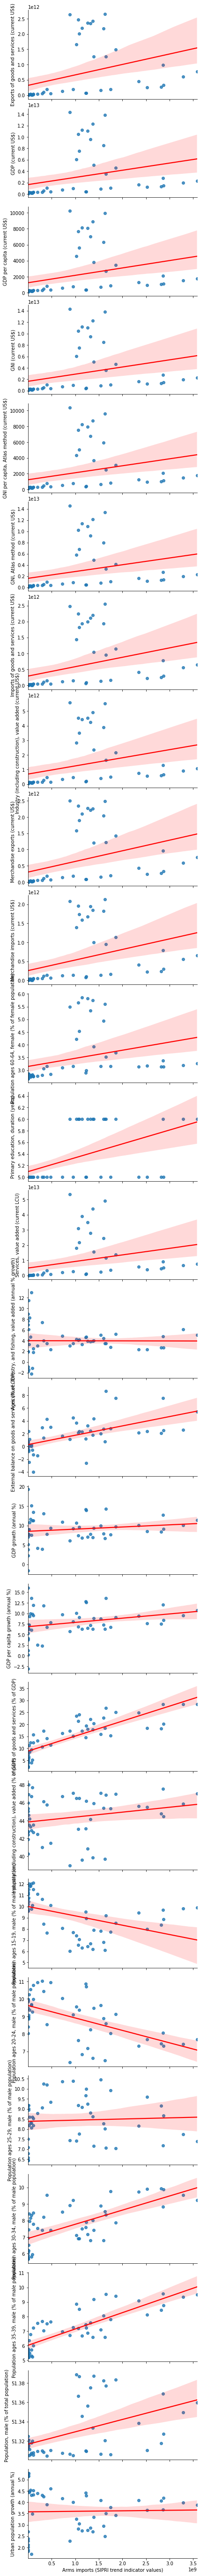

In [35]:
import seaborn as sns

ax = sns.pairplot(df_meas, x_vars='Arms imports (SIPRI trend indicator values)', y_vars=X.columns, kind='reg', plot_kws={'line_kws':{'color':'red'}}, height=3, aspect=2)